In [1]:
# 2D simulation with Particle-in-Cell
using Revise
import Random
Random.seed!(0)
cd("/Users/bach/OneDrive - Politechnika Warszawska/projects/2019/iskra")
include("problem/configuration.jl")
include("problem/units_and_constants.jl")
config = Config()
############################################
Te = 30_000K
Ti = 300K
Tn = 300K
L  = 6.7cm
nHe = 9.64e20
ne = 2.56e14
f  = 13.56MHz
nx = 128
ny = 1
ds = L/nx
ts = 512
Δh = ds

simulationVolume = nx * Δh * ny * Δh
numCells         = nx * ny

electronParticles    = 128 * numCells
totalNumElectrons    = ne * simulationVolume
electronNumRatio     = totalNumElectrons / electronParticles

ionParticles         = 128 * numCells
totalNumIons         = nHe * simulationVolume
ionNumRatio          = totalNumIons / ionParticles

Δt = 1/400f
Lx = nx*Δh
Ly = ny*Δh
############################################
println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("electrons: ", electronParticles, " wg: ", electronNumRatio)
println("ions: ", ionParticles, " wg: ", ionNumRatio)
println("kB Te / me: ", .5thermal_speed(Te, me))

Δt: 1.8436578171091445e-10
Δh: 0.0005234375
Lx: 0.067
electrons: 16384 wg: 547973.6328125001
ions: 16384 wg: 2.0634632110595708e12
kB Te / me: 476807.16512475203


In [2]:
xs = 0m:Δh:Lx
ys = 0m:Δh:Ly
e  = create_kinetic_species("e-", 20_000,-1qe, 1me, electronNumRatio);
iHe = create_kinetic_species("He+", 20_000,+1qe, 3.99mp, electronNumRatio);
He  = FluidSpecies("He", 1.0, 0qe, 3.99mp, nHe*ones(nx+1, ny+1), float(Tn))

se  = create_thermalized_beam(e,  [Lx Ly], [+0.1Δh/Δt 0. 0.]; T=Te, rate=electronParticles/Δt)
siHe = create_thermalized_beam(iHe, [Lx Ly], [-0.1Δh/Δt 0. 0.]; T=Ti, rate=ionParticles/Δt)
using RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = create_uniform_grid(xs, ys)
config.cells   = create_staggered_grid(config.grid)
config.solver  = create_poisson_solver(config.grid, ε0)
config.pusher  = create_boris_pusher()
config.species = [e, iHe, He]
############################################
mx, my = size(config.grid)
bcs = zeros(Int8, mx, my)
bcs[ 1, :] .= 1
bcs[mx, :] .= 2
apply_periodic(config.solver, 1)
apply_dirichlet(config.solver, bcs .== 1, 0.0)
apply_dirichlet(config.solver, bcs .== 2, 0.0)
############################################
using ParticleInCell
using Diagnostics
using XDMF
using Diagnostics

function ParticleInCell.after_push(part, grid)
  ParticleInCell.discard!(part, grid; dims=1)
  ParticleInCell.wrap!(part, grid; dims=2)
end

function ParticleInCell.after_loop(i, t, dt)
  apply_dirichlet(config.solver, bcs .== 1, 450sin(2π*f*t))
  cd("/tmp")
  new_iteration("15_CID", i, t, dt) do it
    save_records(it, "e-/")
    save_records(it, "He+/")
    save_record(it, "rho")
    save_record(it, "phi")
    save_record(it, "E")
    save_record(it, "nHe+")
    save_record(it, "ne-")
  end
end

function ParticleInCell.exit_loop()
  println("Exporting to XDMF...")
  cd("/tmp/15_CID")
  electrons = new_document()
  ions = new_document()
  fields = new_document()
  xdmf(1:ts) do it
    write_species(it, electrons, "e-")
    write_species(it, ions, "He+")
    write_fields(it, fields)
  end
  save_document(electrons, "electrons")
  save_document(ions, "ions")
  save_document(fields, "fields")
end

init(se,  e, Δt)
init(siHe,iHe, Δt)
@time solve(config, Δt, ts)

Registering diagnostics e-/id
Registering diagnostics e-/mass
Registering diagnostics e-/charge
Registering diagnostics e-/weighting
Registering diagnostics e-/momentum
Registering diagnostics e-/position
Registering diagnostics e-/positionOffset/x
Registering diagnostics e-/positionOffset/y
Registering diagnostics e-/positionOffset/z
Registering diagnostics He+/id
Registering diagnostics He+/mass
Registering diagnostics He+/charge
Registering diagnostics He+/weighting
Registering diagnostics He+/momentum
Registering diagnostics He+/position
Registering diagnostics He+/positionOffset/x
Registering diagnostics He+/positionOffset/y
Registering diagnostics He+/positionOffset/z
Registering diagnostics dHe
Registering diagnostics vHe
Registering diagnostics ne-
Registering diagnostics nHe+
Registering diagnostics nHe
Registering diagnostics rho
Registering diagnostics phi
Registering diagnostics E
Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Tim

In [10]:
# Visualization of Particle-in-Cell results
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/15_CID/hdf5")
#pt = ov.ParticleTracker(ts, iteration=1, select=Dict("id"=>[0, electronParticles]),
#    species="e-", preserve_particle_index=false)
it, np = length(ts.iterations), 0#pt.N_selected;
px = zeros(it, np)
py = zeros(it, np)
vx = zeros(it, np)
vy = zeros(it, np)
Ex = zeros(it, my, mx)
phi = zeros(it, my, mx)
rho = zeros(it, my, mx)
nHe = zeros(it, my, mx)
ne  = zeros(it, my, mx)
for i=1:it
    #x, y, ux, uy = ts.get_particle( ["x", "y", "ux", "uy"],
    #    select=pt, iteration=ts.iterations[i], species="e-")
    #px[i, :] = x[:]
    #py[i, :] = y[:]
    #vx[i, :] = ux[:]
    #vy[i, :] = uy[:]
    Ex[i, :, :],= ts.get_field("E", iteration=ts.iterations[i], coord="x")
   phi[i, :, :],= ts.get_field("phi", iteration=ts.iterations[i])
   rho[i, :, :],= ts.get_field("rho", iteration=ts.iterations[i])
   nHe[i, :, :],= ts.get_field("nHe+", iteration=ts.iterations[i])
    ne[i, :, :],= ts.get_field("ne-", iteration=ts.iterations[i])
end

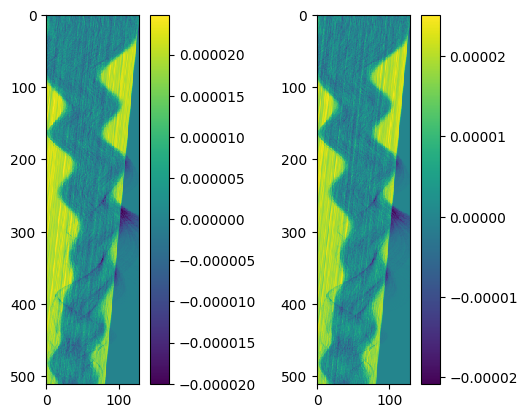

In [11]:
subplot(1,2,1); imshow(rho[:,1,:]); colorbar();
subplot(1,2,2); imshow(rho[:,2,:]); colorbar();

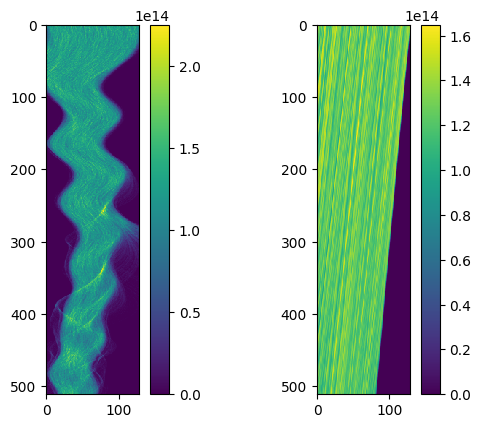

In [12]:
subplot(1,2,1); imshow(ne[:,1,:]); colorbar();
subplot(1,2,2); imshow(nHe[:,2,:]); colorbar();

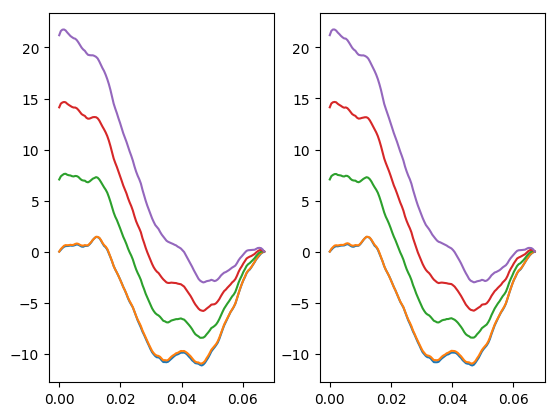

In [13]:
subplot(1,2,1); plot(xs, phi[1,1,:], xs, phi[2,1,:], xs, phi[3,1,:], xs, phi[4,1,:], xs, phi[5,1,:]);
subplot(1,2,2); plot(xs, phi[1,2,:], xs, phi[2,2,:], xs, phi[3,2,:], xs, phi[4,2,:], xs, phi[5,2,:]);

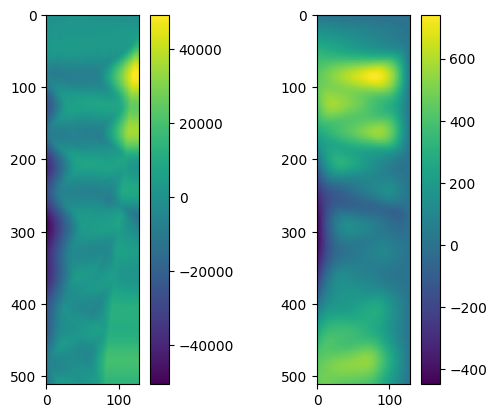

In [14]:
subplot(1,2,1); imshow(Ex[:,1,:]); colorbar();
subplot(1,2,2); imshow(phi[:,1,:]); colorbar();

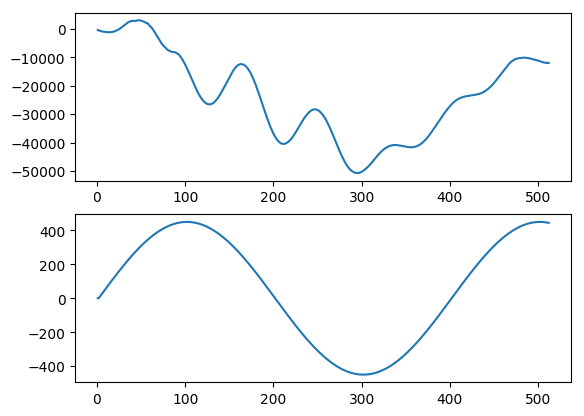

In [15]:
subplot(2,1,1); plot(1:it, Ex[:,1,1]);
subplot(2,1,2); plot(1:it, phi[:,1,1]);

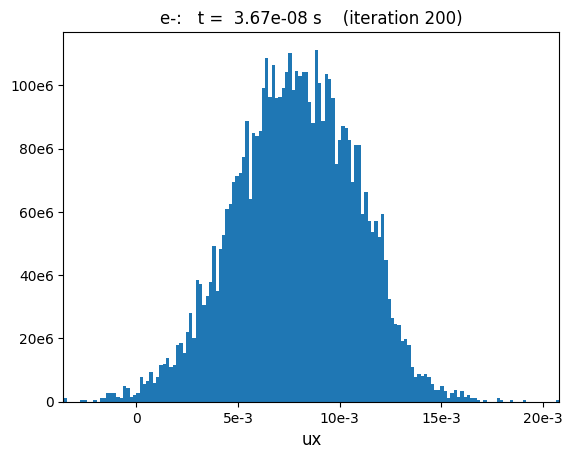

In [16]:
ts.get_particle( ["ux"], iteration=ts.iterations[200], species="e-", plot=true);